In [444]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, GlobalAveragePooling1D, Input, UpSampling1D
from keras.utils import to_categorical
from keras import regularizers

In [397]:
MIN_LENGTH = 24000
NO_TRAINING_SAMPLES = 1000 # select an even #
NO_TEST_SAMPLES = 100

In [398]:
offset = 100
def get_signals(dir, max_no_signals = 10):
    '''
    gets signals from specified directory 
    and returns a (n, l, 1) numpy array
    where n is number of distinct signals and
    l is length of each signal.
    '''
    directory = dir

    list_of_signals = []

    n = 0

    for filename in os.listdir(directory):
        filename = directory + '/' + filename
        list_of_signals.append(np.genfromtxt(filename, delimiter=','))
        n+=1
    
    no_signals = len(list_of_signals) # comment out if doing subsampling for testing
    
    signals = np.zeros([no_signals, MIN_LENGTH])   # replace 5 with n ! 

    for i, arr in enumerate(list_of_signals):
        arr = arr[offset:MIN_LENGTH+offset]
        signals[i] = arr #.reshape(l,1)

    print("Signals loaded. Length of a signal is %d, No. of signals is: %d" % (len(signals[0]), no_signals))
    return signals, no_signals


In [399]:
def plot_signals(signals, name):
    avg = np.average(signals, axis=0)
    std = np.std(signals, axis=0)
    x = range(signals.shape[1])

    plt.style.use('ggplot') #Change/Remove This If you Want
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(x, avg, alpha=0.5, color='red', label=name, linewidth = 1.0)
    ax.fill_between(x, avg - std, avg + std, color='#888888', alpha=0.4)
    ax.fill_between(x, avg - 2*std, avg + 2* std, color='#888888', alpha=0.2)
    ax.legend(loc='best')
    ax.set_ylabel("Signal units?")
    ax.set_xlabel("Time")
    plt.show()

Signals loaded. Length of a signal is 24000, No. of signals is: 1000


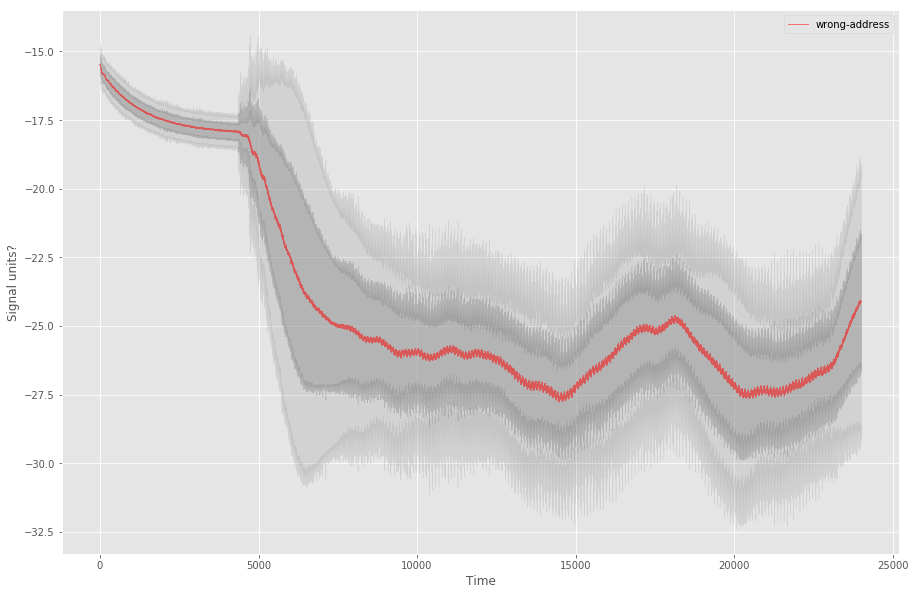

In [400]:
signals1, no_samples_1 = get_signals('../Scripts/Applications/Data_processing/signals', NO_TRAINING_SAMPLES)
plot_signals(signals1, 'wrong-address')

In [401]:
div = 100

def downsample(s, R):
    s = s.reshape(-1, R)
    return s.reshape(-1, R).mean(axis=1)

def downsample_signals(signals):
    downsampled_signals = np.zeros([signals.shape[0], MIN_LENGTH//div])
    
    for i, signal in enumerate(signals):
        downsampled_signals[i] = downsample(signal, div)
        
    return downsampled_signals

In [402]:
downsampled_signals1 = downsample_signals(signals1)

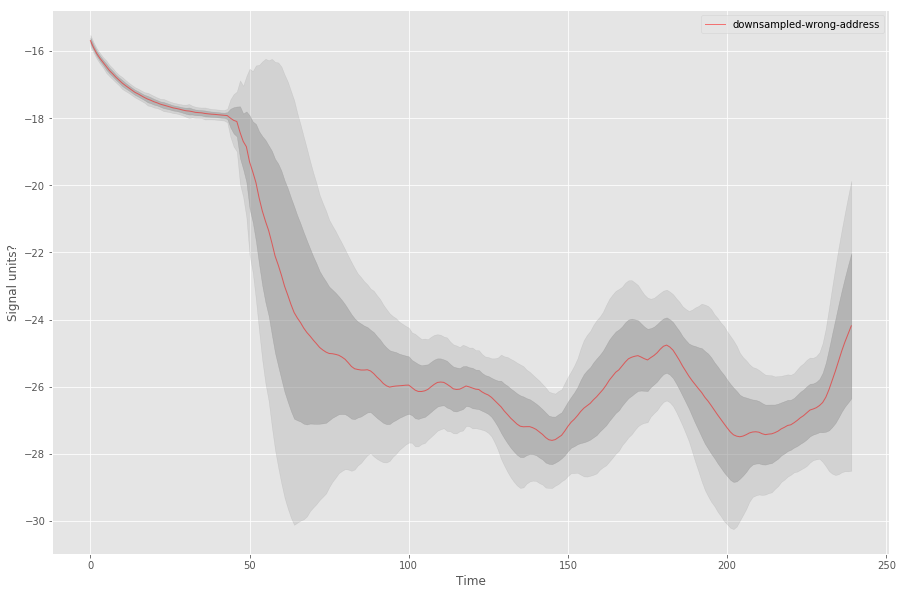

In [403]:
plot_signals(downsampled_signals1, 'downsampled-wrong-address')

In [404]:
signals2, no_samples_2 = get_signals('../Scripts/Applications/Data_processing/signals-2', NO_TRAINING_SAMPLES)

Signals loaded. Length of a signal is 24000, No. of signals is: 990


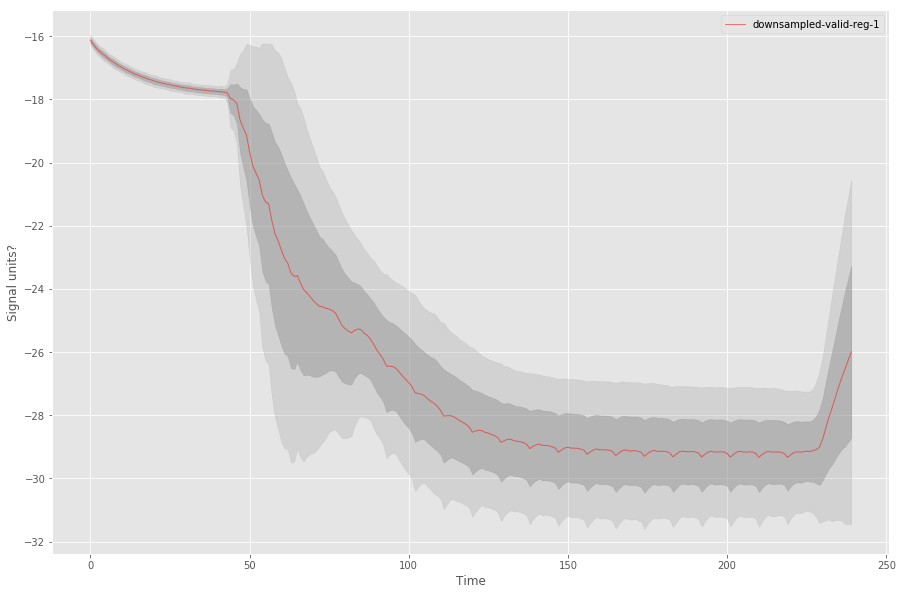

In [405]:
downsampled_signals2 = downsample_signals(signals2)
plot_signals(downsampled_signals2, 'downsampled-valid-reg-1')

In [406]:
# create train/test split (3/4)

x = np.concatenate((downsampled_signals1[0:no_samples_1], 
                    downsampled_signals2[0:no_samples_2]))

y1 = np.ones(no_samples_1)
y2 = np.zeros(no_samples_2)
#y = to_categorical(np.concatenate((y1,y2)))
y = np.concatenate((y1,y2)).reshape(-1,1)

In [407]:
def split(arr, n = len(x) - len(x)//4):
    return arr[:n], arr[n:]

def random_split(x, y):
    """shuffle data, train/test split. returns train_x, train_y, test_x, test_y"""
    tmp = np.concatenate((x,y), axis=1)
    np.random.shuffle(tmp)
    train, test = split(tmp)
    return train[:,:-1], train[:,-1], test[:,:-1], test[:,-1]

train_x, train_y, test_x, test_y = random_split(x,y)

print(train_x.shape)
print(test_x.shape)

(1493, 240)
(497, 240)


In [408]:
seq_length, n_features, n_outputs = train_x.shape[1], 1, 1
print("Sequence length is", seq_length)

train_x = train_x.reshape(-1,seq_length, n_features)
test_x = test_x.reshape(-1, seq_length, n_features)
print(train_x.shape)
print(test_x.shape)

Sequence length is 240
(1493, 240, 1)
(497, 240, 1)


In [409]:
#test_x = np.concatenate((downsample_signals(),
#             downsample_signals(get_signals('../Scripts/Applications/Data_processing/signals-2', 
#                                                        NO_TEST_SAMPLES)))).reshape(NO_TEST_SAMPLES*2,-1,1)

#test_y = to_categorical(np.concatenate((np.ones(10), np.zeros(10))))
#test_y = np.concatenate((np.ones(NO_TEST_SAMPLES), 
#                         np.zeros(NO_TEST_SAMPLES)))
#test_x.shape

In [417]:
verbose, epochs, batch_size = 1, 10, 8

model = Sequential((
    # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
    # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
    # the input timeseries, the activation of each filter at that position.
    Conv1D(filters=8, kernel_size=16, activation='relu', input_shape=(seq_length, n_outputs)),
    MaxPooling1D(),     # Downsample the output of convolution by 2X.
    Conv1D(filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(n_outputs, activation='sigmoid'),     # For binary classification, change the activation to 'sigmoid'
))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [418]:
# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle = True)

Epoch 1/10
1493/1493 [==============================] - 3s 2ms/step - loss: 0.2100 - acc: 0.7522
Epoch 2/10
1493/1493 [==============================] - 1s 509us/step - loss: 0.0838 - acc: 0.9357
Epoch 3/10
1493/1493 [==============================] - 1s 508us/step - loss: 0.0461 - acc: 0.9565
Epoch 4/10
1493/1493 [==============================] - 1s 507us/step - loss: 0.0394 - acc: 0.9598
Epoch 5/10
1493/1493 [==============================] - 1s 523us/step - loss: 0.0368 - acc: 0.9612
Epoch 6/10
1493/1493 [==============================] - 1s 524us/step - loss: 0.0350 - acc: 0.9612
Epoch 7/10
1493/1493 [==============================] - 1s 512us/step - loss: 0.0313 - acc: 0.9652
Epoch 8/10
1493/1493 [==============================] - 1s 522us/step - loss: 0.0328 - acc: 0.9645
Epoch 9/10
1493/1493 [==============================] - 1s 517us/step - loss: 0.0310 - acc: 0.9665
Epoch 10/10
1493/1493 [==============================] - 1s 511us/step - loss: 0.0308 - acc: 0.9652


In [419]:
_, accuracy = model.evaluate(train_x, train_y, batch_size=batch_size, verbose=0)
print(accuracy)
# evaluate model
_, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
print(accuracy)

0.9671801741859375
0.9577464788732394


## Autoencoder
- kernel size is the size of the convolution window, ie. the smaller it is, the smaller the window a feature can examine.
- filter size is the number of features.

In [509]:
# convolutional autoencoder (smaller hidden layer)
verbose, epochs, batch_size = 0, 10, 8

input_sig = Input(shape=(seq_length, 1))

x = Conv1D(filters=20, kernel_size=20,activation='relu', padding='same')(input_sig)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(filters=5, kernel_size=20, activation='relu', padding='same')(x)
encoded = MaxPooling1D(padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv1D(5, kernel_size=20,activation='relu', padding='same')(encoded)
x = UpSampling1D()(x)
x = Conv1D(20, kernel_size=20,activation='relu', padding='same')(x)
x = UpSampling1D()(x)
decoded = Conv1D(1, kernel_size=20,activation='linear', padding='same')(x)

autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
encoder = Model(input_sig, encoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        (None, 240, 1)            0         
_________________________________________________________________
conv1d_399 (Conv1D)          (None, 240, 20)           420       
_________________________________________________________________
max_pooling1d_203 (MaxPoolin (None, 120, 20)           0         
_________________________________________________________________
conv1d_400 (Conv1D)          (None, 120, 5)            2005      
_________________________________________________________________
max_pooling1d_204 (MaxPoolin (None, 60, 5)             0         
_________________________________________________________________
conv1d_401 (Conv1D)          (None, 60, 5)             505       
_________________________________________________________________
up_sampling1d_89 (UpSampling (None, 120, 5)            0         
__________

In [504]:
# SPARSE autoencoder (larger hidden layer)
verbose, epochs, batch_size = 0, 10, 8

input_sig = Input(shape=(seq_length, 1))

x = Conv1D(filters=10, kernel_size=20,activation='relu', padding='same', activity_regularizer=regularizers.l2(1e-5))(input_sig)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(filters=3, kernel_size=20, activation='relu', padding='same', activity_regularizer=regularizers.l2(1e-5))(x)
encoded = MaxPooling1D(2, padding='same')(x)

x = Conv1D(filters=3, kernel_size=20,activation='relu', padding='same', activity_regularizer=regularizers.l2(1e-5))(encoded)
x = UpSampling1D()(x)
x = Conv1D(filters=10, kernel_size=20,activation='relu', padding='same', activity_regularizer=regularizers.l2(1e-5))(x)
x = UpSampling1D()(x)
decoded = Conv1D(filters=1, kernel_size=20,activation='linear', padding='same')(x)

autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
encoder = Model(input_sig, encoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 240, 1)            0         
_________________________________________________________________
conv1d_389 (Conv1D)          (None, 240, 10)           210       
_________________________________________________________________
max_pooling1d_199 (MaxPoolin (None, 120, 10)           0         
_________________________________________________________________
conv1d_390 (Conv1D)          (None, 120, 3)            603       
_________________________________________________________________
max_pooling1d_200 (MaxPoolin (None, 60, 3)             0         
_________________________________________________________________
conv1d_391 (Conv1D)          (None, 60, 3)             183       
_________________________________________________________________
up_sampling1d_85 (UpSampling (None, 120, 3)            0         
__________

In [510]:
autoencoder.fit(train_x, train_x,
                epochs=10,
                batch_size=4,
                shuffle=True,
                validation_data=(test_x, test_x))

Train on 1493 samples, validate on 497 samples
Epoch 1/10
1493/1493 [==============================] - 8s 5ms/step - loss: 16.8558 - val_loss: 1.2740
Epoch 2/10
1493/1493 [==============================] - 4s 2ms/step - loss: 0.8993 - val_loss: 0.6332
Epoch 3/10
1493/1493 [==============================] - 4s 2ms/step - loss: 0.4435 - val_loss: 0.3564
Epoch 4/10
1493/1493 [==============================] - 4s 3ms/step - loss: 0.2889 - val_loss: 0.2450
Epoch 5/10
1493/1493 [==============================] - 4s 3ms/step - loss: 0.2394 - val_loss: 0.2113
Epoch 6/10
1493/1493 [==============================] - 4s 3ms/step - loss: 0.2194 - val_loss: 0.1912
Epoch 7/10
1493/1493 [==============================] - 4s 2ms/step - loss: 0.2130 - val_loss: 0.2379
Epoch 8/10
1493/1493 [==============================] - 3s 2ms/step - loss: 0.2028 - val_loss: 0.3481
Epoch 9/10
1493/1493 [==============================] - 3s 2ms/step - loss: 0.1896 - val_loss: 0.2248
Epoch 10/10
1493/1493 [===========

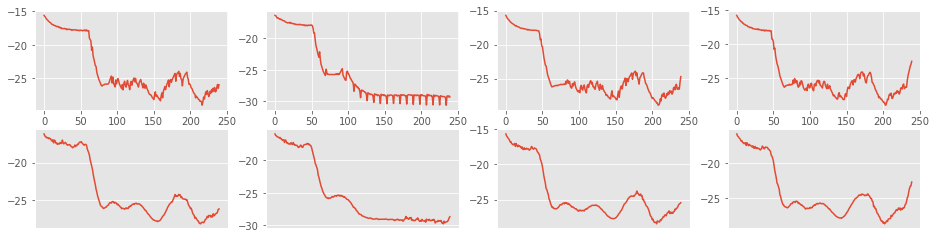

In [511]:
decoded_sigs = autoencoder.predict(test_x)

n = 5
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.plot(test_x[i])
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.plot(decoded_sigs[i])
    ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()

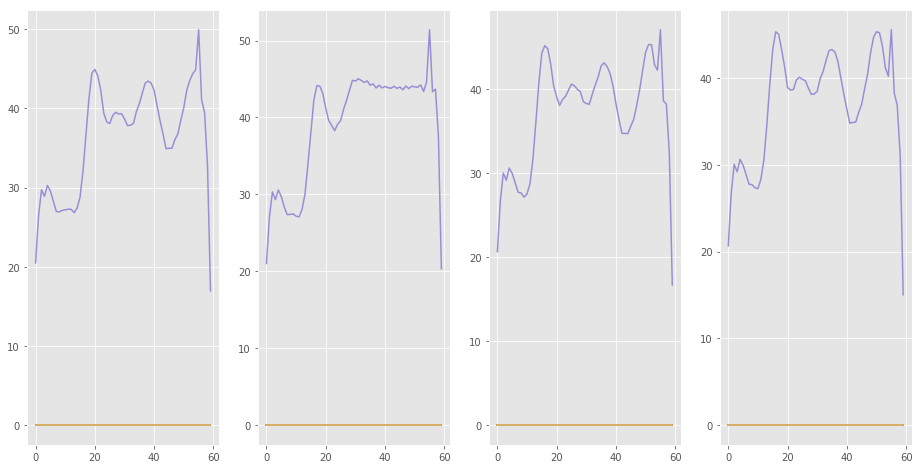

In [512]:
encoded_sigs = encoder.predict(test_x)

n = 5
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.plot(encoded_sigs[i])
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
plt.show()